In [1]:
import math
import numpy as np
from torch import cos, sin
import scipy.optimize as opt
import torch
import torch.nn as nn
%matplotlib ipympl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append("../../../ddn/")
from ddn.pytorch.node import *

from pytorch3d.loss import chamfer_distance
from pytorch3d.ops import sample_farthest_points
from descartes import PolygonPatch
from pytorch3d.io import IO, load_obj, save_obj,load_objs_as_meshes
from pytorch3d.structures import join_meshes_as_batch, Meshes, Pointclouds

from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)

from alpha_shapes import Alpha_Shaper, plot_alpha_shape
from torch import Tensor, tensor

import shapely
import os
import trimesh
import plotly.graph_objects as go

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
torch.autograd.set_detect_anomaly(True)

def least_squares(u0, tgt_vtxs):
    """
    u0 are vertices
    """
    if not torch.is_tensor(u0):
        u0 = torch.tensor(u0)
    if not torch.is_tensor(tgt_vtxs):
        tgt_vtxs = torch.tensor(tgt_vtxs)
    res = torch.square(u0 - tgt_vtxs.flatten()).sum()
    return res.double()

def least_squares_grad(u0, tgt_vtxs):
    if torch.is_tensor(u0):
        u0 = u0.detach().clone()
    else:
        u0 = torch.tensor(u0)
    if torch.is_tensor(tgt_vtxs):
        tgt_vtxs = tgt_vtxs.detach().clone()
    else:
        tgt_vtxs = torch.tensor(tgt_vtxs)
        
    # Ensure that u0 requires gradients
    gradient = 2 * (u0 - tgt_vtxs.flatten())
    return gradient.double()


def calculate_volume(vertices, faces):
    face_vertices = vertices[faces]  # (F, 3, 3)
    v0, v1, v2 = face_vertices[:, 0, :], face_vertices[:, 1, :], face_vertices[:, 2, :]
    
    # Compute determinant of the 3x3 matrix [v0, v1, v2]
    face_volumes = torch.det(torch.stack([v0, v1, v2], dim=-1)) / 6.0  # Shape: (F,)
    volume = face_volumes.sum()
    return volume.abs()


def volume_constraint(x, faces, tgt_vol):
    """
    Calculate the volume of a mesh using PyTorch tensors.
    Args:
        vertices_torch: Nx3 tensor of vertex coordinates
        faces: Mx3 array of face indices
    Returns:
        volume: Total volume of the mesh as a PyTorch scalar
    """
    if not torch.is_tensor(x):
        x = torch.tensor(x)
    if not torch.is_tensor(faces):
        faces = torch.tensor(faces)
    if not torch.is_tensor(tgt_vol):
        tgt_vol = torch.tensor(tgt_vol)

    vertices = x.view(-1,3)
    faces = faces.view(-1,3).int()
    volume = calculate_volume(vertices, faces)
    res = volume.abs() - tgt_vol
    return res.double()

def volume_constraint_grad(x, faces):
    if torch.is_tensor(x):
        x = x.detach().clone()
    else:
        x = torch.tensor(x)
    if torch.is_tensor(faces):
        faces = faces.detach().clone()
    else:
        faces = torch.tensor(faces)
    faces = faces.to(dtype=torch.int64)

    vertices_torch = x.view(-1, 3)
    p0 = vertices_torch[faces[:, 0]]  # (F, 3)
    p1 = vertices_torch[faces[:, 1]]  # (F, 3)
    p2 = vertices_torch[faces[:, 2]]  # (F, 3)

    grad_p0 = torch.cross(p1, p2, dim=1) / 6.0
    grad_p1 = torch.cross(p2, p0, dim=1) / 6.0
    grad_p2 = torch.cross(p0, p1, dim=1) / 6.0

    grad_verts = torch.zeros_like(vertices_torch)
    grad_verts.scatter_add_(0, faces[:, 0].unsqueeze(1).expand(-1, 3), grad_p0)
    grad_verts.scatter_add_(0, faces[:, 1].unsqueeze(1).expand(-1, 3), grad_p1)
    grad_verts.scatter_add_(0, faces[:, 2].unsqueeze(1).expand(-1, 3), grad_p2)

    analytical_grad = grad_verts.flatten()
    return analytical_grad 

def padded_to_packed(xs, lengths):
    packed = []
    batch_size = xs.size(0)
    for b in range(batch_size):
        n = lengths[b]
        packed.append(xs[b][:n])
    packed = torch.cat(packed, dim=0)
    return packed

y* = argmin ||X - tgt||^2

target depends on input X

We have mesh points in 3D <-- X
2D edge maps <-- upper level targets

lower level: find Y closest to X that satisfy volume constraint, so Y is being optimised in the lower point

argmin ||X - Y||^2 s.t. vol(Y) = constant

In [4]:
class ConstrainedProjectionNode(EqConstDeclarativeNode):
    """
    Performs a projection of the input points X onto the nearest points Y such that the volume of Y is constant.
    """
    def __init__(self, src: Meshes, tgt: Meshes):
        super().__init__(eps=1.0e-6) # relax tolerance on optimality test 
        self.src = src # source meshes (B,)
        # self.tgt = tgt # target meshes (B,)
        self.b = len(src)

    def objective(self, xs: torch.Tensor, y: torch.Tensor, scatter_add=False):
        """
        Calculates sum of squared differences between source and target meshes.

        Args:
            xs (torch.Tensor): a padded (B, max Vi, 3) tensor of the original vertices
            y (torch.Tensor): a padded (B, max Vi, 3) tensor of the projected vertices        
        """
        src_verts = padded_to_packed(xs, self.src.num_verts_per_mesh()).view(-1,3)
        tgt_verts = padded_to_packed(y, self.src.num_verts_per_mesh()).view(-1,3)

        sqr_diffs = torch.square(src_verts - tgt_verts).sum(dim=-1) # (sum(V_i))
        n_batches = len(self.src)
        sse = torch.zeros(n_batches, dtype=sqr_diffs.dtype)
        if scatter_add:
            sse.scatter_add_(0, self.src.verts_packed_to_mesh_idx(), sqr_diffs)
        else:
            n_verts_per_mesh = self.src.num_verts_per_mesh()
            for i in range(n_batches):
                mesh_to_vert = self.src.mesh_to_verts_packed_first_idx()  # Index of first face per mesh
                start = mesh_to_vert[i]
                end = start + n_verts_per_mesh[i]
                sse[i] = sqr_diffs[start:end].sum()  # Sum over all faces
        return sse

    def equality_constraints(self, xs, y, scatter_add=False):
        """
        Enforces volume constraint of projected points
        Assumes same number of vertices in each projected mesh currently

        Args:
            xs (torch.Tensor): a padded (B, max Vi, 3) tensor of the original vertices
            y (torch.Tensor): a padded (B, max Vi, 3) tensor of the projected vertices
        """
        n_batches = len(self.src)
        y_packed = padded_to_packed(y, self.src.num_verts_per_mesh())
        verts_packed = y_packed.view(-1,3) # (sum(V_i), 3)

        faces_packed = self.src.faces_packed()  # (sum(F_i), 3)
        face_vertices = verts_packed[faces_packed]  # (sum(F_i), 3, 3)
        
        # Calculate tetrahedron volumes for each face
        v0, v1, v2 = face_vertices[:, 0, :], face_vertices[:, 1, :], face_vertices[:, 2, :]
        cross_product = torch.cross(v0, v1, dim=-1)  # (F, 3)
        face_volumes = torch.sum(cross_product * v2, dim=-1) / 6.0  # (F,)
        volumes = torch.zeros(n_batches, device=verts_packed.device, dtype=face_volumes.dtype)
        if scatter_add:
            volumes.scatter_add_(0, self.src.faces_packed_to_mesh_idx(), face_volumes)
        else:
            n_faces_per_mesh = self.src.num_faces_per_mesh()
            for i in range(n_batches):
                mesh_to_face = self.src.mesh_to_faces_packed_first_idx()  # Index of first face per mesh
                start = mesh_to_face[i]
                end = start + n_faces_per_mesh[i]
                volumes[i] = face_volumes[start:end].sum()  # Sum over all faces

        volumes = volumes.abs()
        return volumes  # Shape: (B,)    
    
    def solve(self, xs: torch.Tensor):
        """Projects the vertices onto the target mesh vertices across batches.

        Args:
            xs (torch.Tensor): a padded (B, max Vi, 3) tensor of vertices in the batched meshes

        Returns:
            results (torch.Tensor): a padded (B, max Vi, 3) tensor of the projected vertices
        """
        n_batches = len(self.src)
        num_verts_per_mesh = self.src.num_verts_per_mesh()
        results = torch.zeros((n_batches, num_verts_per_mesh.max(), 3), dtype=torch.double)
        for batch in range(n_batches):
            n_verts = num_verts_per_mesh[batch]
            verts = xs[batch][:n_verts].flatten().detach().double().cpu().numpy()
            faces = self.src[batch].faces_packed().detach().int().cpu().numpy()
            
            # Y = xs[batch][:n_verts].flatten().detach().double().cpu() * 2
            # Y = Y.numpy()
            Y = xs[batch][:n_verts].flatten().detach().double().cpu().numpy() 

            with torch.no_grad():
                src_vtx = self.src[batch].verts_packed().detach()
                src_faces = self.src[batch].faces_packed().detach()
                vol = calculate_volume(src_vtx, src_faces)

            eq_constraint = {
                'type': 'eq',
                'fun' : lambda u: volume_constraint(u, faces, vol).cpu().numpy(),
                'jac' : lambda u: volume_constraint_grad(u, faces).cpu().numpy(),
            }

            res = opt.minimize(
                lambda u: least_squares(u, verts).detach().cpu().numpy(),
                Y,
                method='SLSQP',
                jac=lambda u: least_squares_grad(u, verts).cpu().numpy(),
                constraints=[eq_constraint],
                options={'ftol': 1e-4, 'iprint': 2, 'maxiter': 100}
            )

            if not res.success:
                print("FAILED:", res.message)
            results[batch] = torch.tensor(res.x, dtype=torch.double, requires_grad=True).view(-1,3)
        results = torch.nn.utils.rnn.pad_sequence(results, batch_first=True)
        return results,None
    

class ConstrainedProjectionFunction(DeclarativeFunction):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)


Pseudo code:
- load in the meshes
- inner problem needs access to the vertices, number of meshes, faces, and indexing
- outer problem needs access to projected vertices, number of meshes, and indexing. Also needs projection matrices, and edge maps of renders, so perform edge detection of renders beforehand.

just provide both with the meshes lol

Projection:
Get the indexing correct for the vertices, take the projection of these vertices

In [5]:
# outer problem

def create_padded_tensor(vertices, vert2mesh, max_V, B):
    padded = torch.zeros((B, max_V, 3),device=vertices.device)
    for i in range(B):
        mesh_vertices = vertices[vert2mesh == i]
        num_vertices = mesh_vertices.shape[0]
        padded[i, :num_vertices, :] = mesh_vertices
    return padded

def get_boundary(projected_pts, alpha=10.0):
    # Create a detached copy for Alpha_Shaper
    projected_pts_detached = projected_pts.detach().clone()
    
    # Use the detached copy with Alpha_Shaper
    shaper = Alpha_Shaper(projected_pts_detached)
    alpha_shape = shaper.get_shape(alpha)
    while isinstance(alpha_shape, shapely.MultiPolygon) or isinstance(alpha_shape, shapely.GeometryCollection):
        alpha -= 1
        alpha_shape = shaper.get_shape(alpha)
    boundary = torch.tensor(alpha_shape.exterior.coords.xy, dtype=torch.double)
    
    # Find indices of boundary points
    boundary_indices = torch.where(
        torch.any(torch.isclose(projected_pts_detached[:, None], boundary.T, atol=1e-6).all(dim=-1), dim=1)
    )[0]
    
    # Index back into the original tensor with gradients
    boundary_pts = projected_pts[boundary_indices]
    return boundary_pts

class PyTorchChamferLoss(nn.Module):
    def __init__(self, src: Meshes, tgt: Meshes, projmatrices, edgemap_info):
        super().__init__()
        self.src = src  # (B meshes)
        self.tgt = tgt  # (B meshes)
        self.projmatrices = projmatrices # (P, 3, 4)
        self.edgemaps = edgemap_info[0] # (P, max_Ni, 2)
        self.edgemaps_len = edgemap_info[1] # (P,)
    
    def project_vertices(self, vertices):
        """
        Projects a set of vertices into multiple views using different projection matrices.
        Args:
            vertices: Tensor of shape (N, 3), representing 3D vertex positions.
        Returns:
            Tensor of shape (P, N, 2), containing projected 2D points in each view.
        """
        V = vertices.shape[0]
        projection_matrices = self.projmatrices

        ones = torch.ones((V, 1), dtype=vertices.dtype, device=vertices.device)
        vertices_homogeneous = torch.cat([vertices, ones], dim=1).double()  # Shape: (V, 4)

        # Perform batched matrix multiplication (P, 3, 4) @ (V, 4, 1) -> (P, V, 3)
        projected = torch.einsum("pij,vj->pvi", projection_matrices, vertices_homogeneous)  # (P, V, 3)
        
        projected_cartesian = projected[:, :, :2] / projected[:, :, 2:3]  # (P, V, 2)

        return projected_cartesian

        
    def forward(self, y):
        B, P = len(self.src), self.projmatrices.size(0)
        vertices = y
        # project vertices
        num_verts_per_mesh = self.src.num_verts_per_mesh()
        projected_vertices = [] # (B, P, V, 2)
        for b in range(B):
            end = num_verts_per_mesh[b]
            projverts = self.project_vertices(vertices[b][:end,:])  # Shape: (P, V, 2)
            projected_vertices.append(projverts)  # Store without padding

        # get boundaries
        boundaries = [] 
        boundary_lengths = torch.zeros(B, P)
        for b, batch in enumerate(projected_vertices):
            boundaries_b = []
            for p, projverts in enumerate(batch):
                boundary = get_boundary(projverts)
                boundaries_b.append(boundary)
                boundary_lengths[b,p] = len(boundary)
            padded_boundaries = torch.nn.utils.rnn.pad_sequence(boundaries_b, batch_first=True, padding_value=0.0)
            boundaries.append(padded_boundaries)

        # perform chamfer
        chamfer_loss = torch.zeros(B)
        for b in range(B):
            boundaries_b = boundaries[b].float()
            edgemaps_b = self.edgemaps[b].float()
            res, _ = chamfer_distance(  x=boundaries_b,
                                        y=edgemaps_b,
                                        x_lengths=boundary_lengths[b].long(),
                                        y_lengths=self.edgemaps_len[b].long(),
                                        batch_reduction="mean",
                                        point_reduction="mean")
            chamfer_loss[b] = res.sum()
        return chamfer_loss.double() * 10



In [6]:
def chamfer_gt(mesh, src:Meshes, tgt:Meshes):
    res,_ = chamfer_distance(x=mesh.detach().float(), 
                             y=tgt.verts_padded().float().detach(),
                             x_lengths=src.num_verts_per_mesh(),
                             y_lengths=tgt.num_verts_per_mesh(),
                             batch_reduction=None,
                             point_reduction="mean")
    # print("Chamfer", res.size())
    return res.tolist() # (B,)


def sse_gt(mesh, src:Meshes, tgt:Meshes):
    sqr_diff = torch.square(mesh - tgt.verts_padded().detach())
    sse = sqr_diff.sum(dim=(1, 2))
    # print("sqrdiff", sqr_diff.size(),"sse", sse.size(), "tgt", tgt.verts_padded().size())
    return sse.tolist() # (B,)


def iou_gt(mesh, src:Meshes, tgt:Meshes,engine='manifold'):
    batch_size = len(mesh)
    ious = []
    gt = tgt.verts_padded()
    for b in range(batch_size):
        num_verts_src = src.num_verts_per_mesh()[b].item()
        num_verts_tgt = tgt.num_verts_per_mesh()[b].item()
        
        mesh_trimesh = trimesh.Trimesh(vertices=mesh[b][:num_verts_src].detach().cpu().numpy(), 
                                       faces=src[b].faces_packed().detach().cpu().numpy())
        gt_trimesh = trimesh.Trimesh(vertices=gt[b][:num_verts_tgt].detach().cpu().numpy(), 
                                     faces=tgt[b].faces_packed().detach().cpu().numpy())
        intersection = mesh_trimesh.intersection(other=gt_trimesh, engine=engine)
        union = mesh_trimesh.union(other=gt_trimesh, engine=engine)
        
        if union.volume == 0:  # Handle edge case
            iou = 0.0
        else:
            iou = intersection.volume / union.volume
        ious.append(iou)
    return ious # (B,)

In [7]:
def plot_projections(projverts, projmats, edgemaps):
    plt.ioff()  # Disable interactive mode

    P, _, _ = projmats.shape
    edge_coords, edge_lens = edgemaps
    fig, axes = plt.subplots(1, P, figsize=(2 * P, 2))  # Increase figure size
    if P == 1:
        axes = [axes]  # Ensure iterable for a single subplot case

    for i in range(P):
        proj_2d_hom = (projmats[i] @ torch.cat([projverts, torch.ones(projverts.shape[0], 1)], dim=1).T).T
        proj_2d = proj_2d_hom[:, :2] / proj_2d_hom[:, 2:3]  # Normalize by depth

        boundary_pts = get_boundary(proj_2d)
        valid_edges = edge_coords[i, :edge_lens[i]]

        ax = axes[i]
        ax.scatter(proj_2d[:, 0], proj_2d[:, 1], c='b', s=8, label="Projected Vertices")
        ax.scatter(valid_edges[:, 0], valid_edges[:, 1], c='r', s=3, label="Edge Coordinates")
        ax.scatter(boundary_pts[:, 0], boundary_pts[:, 1], c='g', s=3, label="Boundary Points")

        ax.set_title(f"Projection {i+1}", fontsize=10)  # Reduce title size
        ax.set_xlabel("x", fontsize=8)
        ax.set_ylabel("y", fontsize=8)
        
        ax.tick_params(axis='both', which='major', labelsize=6)  # Reduce tick label size
        ax.axis("equal")
        ax.invert_yaxis()

    plt.tight_layout(pad=0.5)  # Reduce whitespace
    plt.subplots_adjust(wspace=0.1)  # Reduce horizontal space
    plt.show()
    plt.close(fig)


class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

def outer_problem(src: Meshes, tgt: Meshes, projmats, edgemap_info, n_iters, lr, moment, verbose=True):
    node = ConstrainedProjectionNode(src, tgt)
    verts_init = src.verts_padded() # (B, max Vi, 3)
    verts_init.requires_grad = True
    projverts_init = node.solve(verts_init)
    # apply solve
    projverts_init = ConstrainedProjectionFunction.apply(node, verts_init) # (B, max Vi, 3)

    chamfer_loss = PyTorchChamferLoss(src, tgt, projmats, edgemap_info)

    history = [projverts_init]
    verts = verts_init.clone().detach().requires_grad_(True)

    optimiser = torch.optim.SGD([verts], lr=lr, momentum=moment)
    a,b = edgemap_info
    a,b = a[0], b[0]

    plot_projections(verts.detach().squeeze().double(), projmats, (a,b))

    min_loss = float("inf")
    best_verts = None
    # verts_prev = None
    for i in range(n_iters):
        optimiser.zero_grad(set_to_none=True)
        projverts = ConstrainedProjectionFunction.apply(node, verts)
        history.append(projverts.detach().clone())
        loss = chamfer_loss(projverts)
        colour = bcolors.FAIL
        if loss.item() < min_loss:
            min_loss = loss.item()
            best_verts = projverts.detach().clone()
            colour = bcolors.OKGREEN
        loss.backward()
        optimiser.step()
        if verbose:
            # print(f"{i:4d} Loss: {loss.item()} Gradient: {verts.grad}")
            # SSE: {(torch.norm(projverts - verts_init)**2).sum()} Chamfer: {chamfer_distance(projverts.float(),verts_init.float())[0].sum()}
            print(f"{i:4d} Loss: {colour}{loss.item():.3f}{bcolors.ENDC} Volume: {calculate_volume(projverts[0], src[0].faces_packed()):.3f}")
            print(f"GT Chamfer: [{', '.join(f'{x:.3f}' for x in chamfer_gt(projverts, src, tgt))}] "
                f"GT SSE: [{', '.join(f'{x:.3f}' for x in sse_gt(projverts, src, tgt))}] "
                f"GT IoU: [{', '.join(f'{x:.3f}' for x in iou_gt(projverts, src, tgt))}]")
            if i % 50 == 49:
                plot_projections(projverts.detach().squeeze().double(), projmats, (a,b))
    return best_verts

In [8]:
from utils import load_renders, load_camera_matrices, get_projmats_and_edgemap_info
import cv2
from cv2.typing import MatLike

# Apply Canny edge detection
def canny_edge_map(img: MatLike, options):
    equalise, t1, t2 = options
    # convert to grayscale
    img_greyscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if equalise:
        img_greyscale = cv2.equalizeHist(img_greyscale)
    # apply edge detection
    # edge_map = cv2.Canny(img_greyscale, threshold1=20, threshold2=100)
    # edge_map = cv2.Canny(img_greyscale, threshold1=15, threshold2=250)
    edge_map = cv2.Canny(img_greyscale, threshold1=t1, threshold2=t2)
    # return edge map
    return edge_map

def get_edgemaps(renders, options):
    edgemaps = {}
    edgemaps_len = {}
    for k,v in renders.items():
        views = {}
        views_len = {}
        for num, img in v.items():
            edges = canny_edge_map(img, options[num])
            edge_coords = np.argwhere(edges > 0)
            edge_coords = edge_coords[:, [1,0]]  
            views[num] = torch.tensor(edge_coords)
            views_len[num] = len(edge_coords)
        edgemaps[k] = views
        edgemaps_len[k] = views_len
    return edgemaps, edgemaps_len


paths = [os.path.join("../data/meshes/", f"{name}_2.obj") for name in ["sphere", "balloon", "parabola", "rstrawberry"]]
sphere, balloon, parabola, rstrawberry = load_objs_as_meshes(paths)

/home/jeffrey/miniconda3/envs/venv/lib/python3.11/site-packages/pytorch3d/io/obj_io.py:547: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


In [9]:
def plot_vertices(verts_list):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    
    if not isinstance(verts_list, list):
        x, y, z = verts_list.clone().detach().cpu().squeeze().unbind(1)
        ax.scatter3D(x, z, -y)
    else:
        colors = ['b',  'g', 'r' , 'm', 'c', 'y']  # Define some colors for different sets
        marker_size = 5  # Make points smaller
    
        for i, verts in enumerate(verts_list):
            x, y, z = verts.clone().detach().cpu().squeeze().unbind(1)
            ax.scatter3D(x, z, -y, color=colors[i % len(colors)], s=marker_size, label=f"Set {i+1}")    
    
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_aspect("equal")
    ax.view_init(190, 30)
    ax.legend()
    plt.show()


## Urban background

In [10]:
renders_path = "../data/urban/renders"
renders = load_renders(renders_path)
options = [
    (False, 40, 250),
    (False, 40, 250), # skip, bad one
    (False, 40, 250),
    (False, 10, 300)
]
edgemaps, edgemaps_len = get_edgemaps(renders,options)
matrices_path = "../data/urban/cameras"
matrices = load_camera_matrices(matrices_path)

In [11]:
print(calculate_volume(sphere.verts_packed(), sphere.faces_packed()), calculate_volume(balloon.verts_packed(), balloon.faces_packed()))

tensor(4.2494) tensor(4.2485)


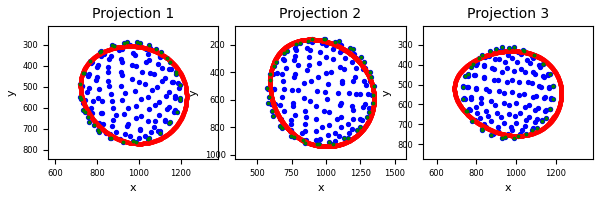

/home/jeffrey/miniconda3/envs/venv/lib/python3.11/site-packages/ddn/pytorch/node.py:521: UserWarning: Constraints not satisfied exactly:
4.249395997599302
  warnings.warn("Constraints not satisfied exactly:\n{}".format(


   0 Loss: 12100.370 Volume: 4.249
GT Chamfer: [0.034] GT SSE: [3.016] GT IoU: [0.801]


/home/jeffrey/miniconda3/envs/venv/lib/python3.11/site-packages/ddn/pytorch/node.py:521: UserWarning: Constraints not satisfied exactly:
4.249418255579167
  warnings.warn("Constraints not satisfied exactly:\n{}".format(


   1 Loss: 11374.847 Volume: 4.249
GT Chamfer: [0.033] GT SSE: [2.981] GT IoU: [0.803]


/home/jeffrey/miniconda3/envs/venv/lib/python3.11/site-packages/ddn/pytorch/node.py:521: UserWarning: Constraints not satisfied exactly:
4.249487055665101
  warnings.warn("Constraints not satisfied exactly:\n{}".format(


   2 Loss: 10368.811 Volume: 4.249
GT Chamfer: [0.033] GT SSE: [2.933] GT IoU: [0.807]


/home/jeffrey/miniconda3/envs/venv/lib/python3.11/site-packages/ddn/pytorch/node.py:521: UserWarning: Constraints not satisfied exactly:
4.2493963249808795
  warnings.warn("Constraints not satisfied exactly:\n{}".format(


   3 Loss: 9449.527 Volume: 4.249
GT Chamfer: [0.032] GT SSE: [2.883] GT IoU: [0.811]


/home/jeffrey/miniconda3/envs/venv/lib/python3.11/site-packages/ddn/pytorch/node.py:521: UserWarning: Constraints not satisfied exactly:
4.249396326509191
  warnings.warn("Constraints not satisfied exactly:\n{}".format(


   4 Loss: 8579.217 Volume: 4.249
GT Chamfer: [0.031] GT SSE: [2.835] GT IoU: [0.815]


/home/jeffrey/miniconda3/envs/venv/lib/python3.11/site-packages/ddn/pytorch/node.py:521: UserWarning: Constraints not satisfied exactly:
4.2493963289797385
  warnings.warn("Constraints not satisfied exactly:\n{}".format(


   5 Loss: 7682.512 Volume: 4.249
GT Chamfer: [0.031] GT SSE: [2.791] GT IoU: [0.819]


/home/jeffrey/miniconda3/envs/venv/lib/python3.11/site-packages/ddn/pytorch/node.py:521: UserWarning: Constraints not satisfied exactly:
4.249396332168111
  warnings.warn("Constraints not satisfied exactly:\n{}".format(


   6 Loss: 6993.681 Volume: 4.249
GT Chamfer: [0.030] GT SSE: [2.752] GT IoU: [0.822]


/home/jeffrey/miniconda3/envs/venv/lib/python3.11/site-packages/ddn/pytorch/node.py:521: UserWarning: Constraints not satisfied exactly:
4.249396335700925
  warnings.warn("Constraints not satisfied exactly:\n{}".format(


   7 Loss: 6439.687 Volume: 4.249
GT Chamfer: [0.030] GT SSE: [2.718] GT IoU: [0.825]


/home/jeffrey/miniconda3/envs/venv/lib/python3.11/site-packages/ddn/pytorch/node.py:521: UserWarning: Constraints not satisfied exactly:
4.249396339254762
  warnings.warn("Constraints not satisfied exactly:\n{}".format(


   8 Loss: 5978.432 Volume: 4.249
GT Chamfer: [0.030] GT SSE: [2.688] GT IoU: [0.828]


/home/jeffrey/miniconda3/envs/venv/lib/python3.11/site-packages/ddn/pytorch/node.py:521: UserWarning: Constraints not satisfied exactly:
4.249396342614165
  warnings.warn("Constraints not satisfied exactly:\n{}".format(


   9 Loss: 5546.098 Volume: 4.249
GT Chamfer: [0.029] GT SSE: [2.661] GT IoU: [0.831]


/home/jeffrey/miniconda3/envs/venv/lib/python3.11/site-packages/ddn/pytorch/node.py:521: UserWarning: Constraints not satisfied exactly:
4.249396345655608
  warnings.warn("Constraints not satisfied exactly:\n{}".format(


  10 Loss: 5213.826 Volume: 4.249
GT Chamfer: [0.029] GT SSE: [2.637] GT IoU: [0.834]


/home/jeffrey/miniconda3/envs/venv/lib/python3.11/site-packages/ddn/pytorch/node.py:521: UserWarning: Constraints not satisfied exactly:
4.249396348331556
  warnings.warn("Constraints not satisfied exactly:\n{}".format(


  11 Loss: 4887.062 Volume: 4.249
GT Chamfer: [0.029] GT SSE: [2.616] GT IoU: [0.836]


/home/jeffrey/miniconda3/envs/venv/lib/python3.11/site-packages/ddn/pytorch/node.py:521: UserWarning: Constraints not satisfied exactly:
4.249396350645849
  warnings.warn("Constraints not satisfied exactly:\n{}".format(


  12 Loss: 4597.236 Volume: 4.249
GT Chamfer: [0.029] GT SSE: [2.597] GT IoU: [0.838]


/home/jeffrey/miniconda3/envs/venv/lib/python3.11/site-packages/ddn/pytorch/node.py:521: UserWarning: Constraints not satisfied exactly:
4.249396352625207
  warnings.warn("Constraints not satisfied exactly:\n{}".format(


  13 Loss: 4378.444 Volume: 4.249
GT Chamfer: [0.028] GT SSE: [2.579] GT IoU: [0.841]


/home/jeffrey/miniconda3/envs/venv/lib/python3.11/site-packages/ddn/pytorch/node.py:521: UserWarning: Constraints not satisfied exactly:
4.249396354311935
  warnings.warn("Constraints not satisfied exactly:\n{}".format(


  14 Loss: 4182.660 Volume: 4.249
GT Chamfer: [0.028] GT SSE: [2.564] GT IoU: [0.843]


/home/jeffrey/miniconda3/envs/venv/lib/python3.11/site-packages/ddn/pytorch/node.py:521: UserWarning: Constraints not satisfied exactly:
4.249396355749779
  warnings.warn("Constraints not satisfied exactly:\n{}".format(
/home/jeffrey/miniconda3/envs/venv/lib/python3.11/site-packages/torch/autograd/graph.py:823: UserWarning: Error detected in ConstrainedProjectionFunctionBackward. Traceback of forward call that caused the error:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/jeffrey/.local/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/jeffrey/.local/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/jeffrey/.local/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start()
  File "/home/jeffrey/.local/lib/python3.11/site-packages/tornado

KeyboardInterrupt: 

In [12]:
view_idx = [0,2,3]
tgt = "balloon"
projmats, tgt_edgemap_info = get_projmats_and_edgemap_info(view_idx, tgt, matrices, edgemaps, edgemaps_len)
batch_tgt_edgemap_info = ([tgt_edgemap_info[0]],[tgt_edgemap_info[1]])
final_verts = outer_problem(sphere, balloon, projmats, batch_tgt_edgemap_info, n_iters=50, lr=1e-6,moment=0.5)

In [ ]:
vertices = np.asarray(final_verts.squeeze())
# vertices = np.asarray(balloon.verts_packed())
faces = np.asarray(sphere.faces_packed())

# Create a Plotly 3D mesh
fig = go.Figure(data=[go.Mesh3d(
    x=vertices[:, 0],
    y=vertices[:, 1],
    z=vertices[:, 2],
    i=faces[:, 0],
    j=faces[:, 1],
    k=faces[:, 2],
    opacity=1,
    color="lightblue"
)])

vertices = np.asarray(balloon.verts_packed())
faces = np.asarray(sphere.faces_packed())

fig.add_trace(go.Mesh3d(
    x=vertices[:, 0],
    y=vertices[:, 1],
    z=vertices[:, 2],
    i=faces[:, 0],
    j=faces[:, 1],
    k=faces[:, 2],
    opacity=0.1,
    color="red"
))

# fig.add_trace(go.Scatter3d(
#     x=vertices[:, 0],
#     y=vertices[:, 1],
#     z=vertices[:, 2],
#     mode='markers',
#     marker=dict(
#         size=4,  # Adjust size of the points
#         color='red',  # Color of the vertices
#         opacity=1
#     )
# ))

# Update layout for better presentation
fig.update_layout(
    scene=dict(
        xaxis=dict(title="X"),
        yaxis=dict(title="Y"),
        zaxis=dict(title="Z"),
    ),
    title="3D Mesh Visualization"
)

# Show the figure
fig.show()


In [ ]:
plot_vertices(sphere.verts_packed())
plot_vertices(final_verts)
plot_vertices(balloon.verts_packed())

## Sky background

In [13]:
renders_path = "../data/sky/renders"
renders = load_renders(renders_path)
# edgemaps, edgemaps_len = get_edgemaps(renders,t1=20,t2=150)
matrices_path = "../data/sky/cameras"
matrices = load_camera_matrices(matrices_path)

In [14]:
view_idx = [0,1,2,3,5,6,7,8,9,10,11]
tgt = "balloon"
options=[
    (True, 50, 200), #0
    (False, 5, 120),
    (False, 10, 180),
    (True, 40, 600),
    (True, 40, 600),
    (False, 0, 180), # bad
    (True, 200, 900),
    (False, 10, 200),
    (False, 10, 200),
    (False, 20, 250),
    (False, 0, 300),
    (True, 100, 900), # meh
]
edgemaps, edgemaps_len = get_edgemaps(renders,options)
projmats, tgt_edgemap_info = get_projmats_and_edgemap_info(view_idx, tgt, matrices, edgemaps, edgemaps_len)
batch_tgt_edgemap_info = ([tgt_edgemap_info[0]],[tgt_edgemap_info[1]])

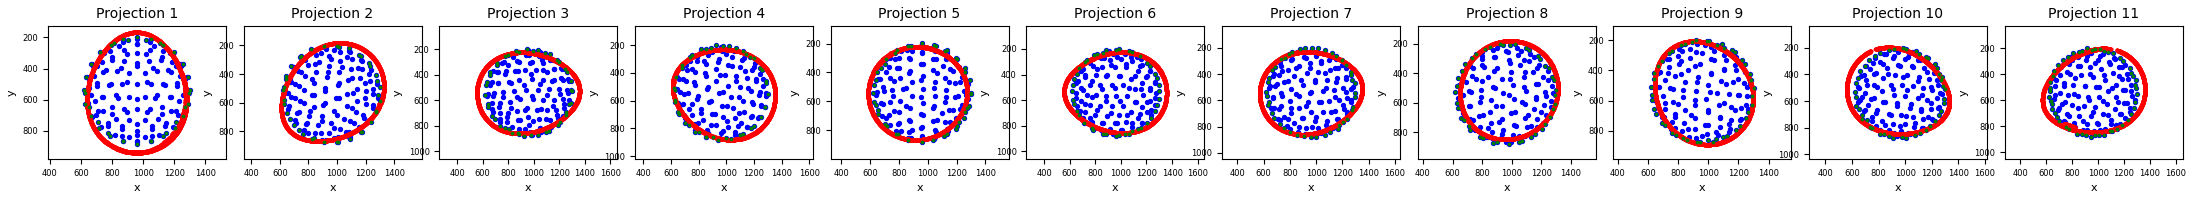

In [15]:
plot_projections(sphere.verts_packed().detach().double(), projmats, tgt_edgemap_info)    

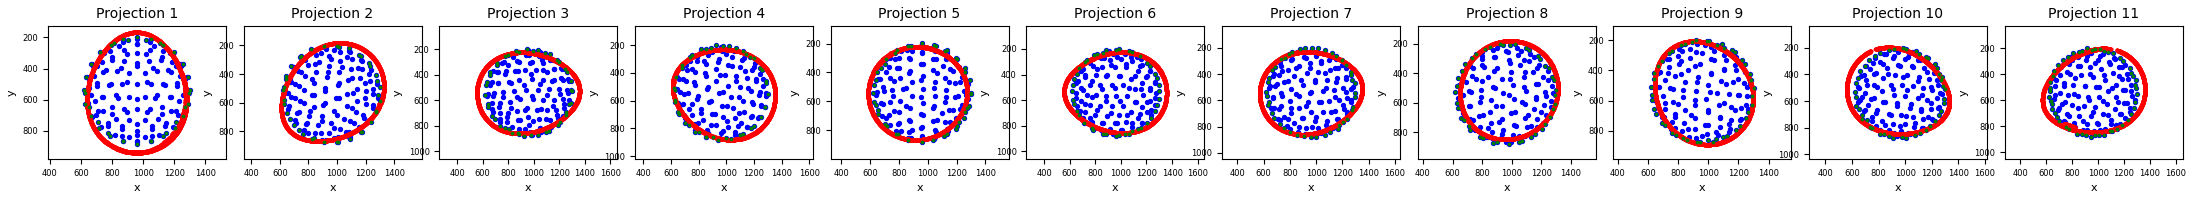

   0 Loss: 22454.482 Volume: 4.249
GT Chamfer: [0.034] GT SSE: [3.016] GT IoU: [0.801]


/home/jeffrey/miniconda3/envs/venv/lib/python3.11/site-packages/ddn/pytorch/node.py:521: UserWarning: Constraints not satisfied exactly:
4.249457133896687
  warnings.warn("Constraints not satisfied exactly:\n{}".format(


   1 Loss: 21298.657 Volume: 4.249
GT Chamfer: [0.033] GT SSE: [2.947] GT IoU: [0.806]


/home/jeffrey/miniconda3/envs/venv/lib/python3.11/site-packages/ddn/pytorch/node.py:521: UserWarning: Constraints not satisfied exactly:
4.249396326567176
  warnings.warn("Constraints not satisfied exactly:\n{}".format(


   2 Loss: 19360.522 Volume: 4.249
GT Chamfer: [0.031] GT SSE: [2.831] GT IoU: [0.814]


/home/jeffrey/miniconda3/envs/venv/lib/python3.11/site-packages/ddn/pytorch/node.py:521: UserWarning: Constraints not satisfied exactly:
4.249396346560237
  warnings.warn("Constraints not satisfied exactly:\n{}".format(


   3 Loss: 16938.253 Volume: 4.249
GT Chamfer: [0.030] GT SSE: [2.689] GT IoU: [0.826]


/home/jeffrey/miniconda3/envs/venv/lib/python3.11/site-packages/ddn/pytorch/node.py:521: UserWarning: Constraints not satisfied exactly:
4.249396433386439
  warnings.warn("Constraints not satisfied exactly:\n{}".format(


   4 Loss: 14477.026 Volume: 4.249
GT Chamfer: [0.028] GT SSE: [2.540] GT IoU: [0.840]


/home/jeffrey/miniconda3/envs/venv/lib/python3.11/site-packages/ddn/pytorch/node.py:521: UserWarning: Constraints not satisfied exactly:
4.249396682939011
  warnings.warn("Constraints not satisfied exactly:\n{}".format(


   5 Loss: 12293.981 Volume: 4.249
GT Chamfer: [0.026] GT SSE: [2.397] GT IoU: [0.855]


/home/jeffrey/miniconda3/envs/venv/lib/python3.11/site-packages/ddn/pytorch/node.py:521: UserWarning: Constraints not satisfied exactly:
4.249397227516139
  warnings.warn("Constraints not satisfied exactly:\n{}".format(


   6 Loss: 10300.371 Volume: 4.249
GT Chamfer: [0.025] GT SSE: [2.270] GT IoU: [0.870]


/home/jeffrey/miniconda3/envs/venv/lib/python3.11/site-packages/ddn/pytorch/node.py:521: UserWarning: Constraints not satisfied exactly:
4.2493982036994105
  warnings.warn("Constraints not satisfied exactly:\n{}".format(


   7 Loss: 8612.615 Volume: 4.249
GT Chamfer: [0.024] GT SSE: [2.161] GT IoU: [0.886]


KeyboardInterrupt: 

In [16]:
final_verts = outer_problem(sphere, balloon, projmats, batch_tgt_edgemap_info, n_iters=36, lr=1e-6,moment=0.8)

In [ ]:
visualise_meshes(Meshes(verts=final_verts.detach(),faces=sphere.faces_packed().unsqueeze(0)), balloon)


In [ ]:
view_idx = [0,1,2,3,5,6,7,8,11]
# view_idx = list(range(12))
tgt = "rstrawberry"
options = [
    (True, 40, 400),
    (False, 5, 250),
    (False, 10, 200),
    (True, 100, 400), # 3, bad
    (False, 5, 200), # 4, meh
    (False, 10, 200),
    (False, 15, 220),
    (False, 15, 250),
    (False, 15, 200),
    (True, 150, 500), # 9, bad
    (False, 0, 320),
    (False, 0, 250)
]
edgemaps, edgemaps_len = get_edgemaps(renders, options)
projmats, tgt_edgemap_info = get_projmats_and_edgemap_info(view_idx, tgt, matrices, edgemaps, edgemaps_len)
batch_tgt_edgemap_info = ([tgt_edgemap_info[0]],[tgt_edgemap_info[1]])


plot_projections(balloon.verts_packed().double(), projmats, tgt_edgemap_info)

In [ ]:
def visualise_meshes(srcmesh, tgtmesh):
    vertices = np.asarray(srcmesh.verts_packed())
    faces = np.asarray(srcmesh.faces_packed())

# Create a Plotly 3D mesh
    fig = go.Figure(data=[go.Mesh3d(
        x=vertices[:, 0],
        y=vertices[:, 1],
        z=vertices[:, 2],
        i=faces[:, 0],
        j=faces[:, 1],
        k=faces[:, 2],
        opacity=1,
        color="lightblue"
    )])

    vertices = np.asarray(tgtmesh.verts_packed())
    faces = np.asarray(tgtmesh.faces_packed())

    fig.add_trace(go.Mesh3d(
        x=vertices[:, 0],
        y=vertices[:, 1],
        z=vertices[:, 2],
        i=faces[:, 0],
        j=faces[:, 1],
        k=faces[:, 2],
        opacity=0.1,
        color="red"
    ))

    # Update layout for better presentation
    fig.update_layout(
        scene=dict(
            xaxis=dict(title="X"),
            yaxis=dict(title="Y"),
            zaxis=dict(title="Z"),
        ),
        title="3D Mesh Visualization"
    )

    # Show the figure
    fig.show()


In [ ]:
renders_path = "../data/sky/renders"
renders = load_renders(renders_path)
matrices_path = "../data/sky/cameras"
matrices = load_camera_matrices(matrices_path)

options=[[
    (True, 50, 200), #0
    (False, 5, 120),
    (False, 10, 180),
    (True, 40, 600),
    (True, 40, 600),
    (False, 0, 180), # bad
    (True, 200, 900),
    (False, 10, 200),
    (False, 10, 200),
    (False, 20, 250),
    (False, 0, 300),
    (True, 100, 900), # meh
], [
    (True, 40, 400),
    (False, 5, 250),
    (False, 10, 200),
    (True, 100, 400), # 3, bad
    (False, 5, 200), # 4, meh
    (False, 10, 200),
    (False, 15, 220),
    (False, 15, 250),
    (False, 15, 200),
    (True, 150, 500), # 9, bad
    (False, 0, 320),
    (False, 0, 250)
]]

views = [[0,1,2,3,5,6,7,8,9,10,11],
         [0,1,2,3,5,6,7,8,11] 
         ]


def pipeline(src, tgts, tgt_names, views, options):
    T = len(tgts)
    print(T)
    src_mesh = src
    renders_path = "../data/sky/renders"
    renders = load_renders(renders_path)
    matrices_path = "../data/sky/cameras"
    matrices = load_camera_matrices(matrices_path)
    for t in range(T):
        view_idx = views[t]
        tgt_mesh = tgts[t]
        edgemaps, edgemaps_len = get_edgemaps(renders, options[t])
        projmats, tgt_edgemap_info = get_projmats_and_edgemap_info(view_idx, tgt_names[t], matrices, edgemaps, edgemaps_len)
        batch_tgt_edgemap_info = ([tgt_edgemap_info[0]],[tgt_edgemap_info[1]])
        final_verts = outer_problem(src_mesh, tgt_mesh, projmats, batch_tgt_edgemap_info, n_iters=20, lr=5e-6,moment=0.5)
        src_mesh = Meshes(verts=final_verts, faces=tgt_mesh.faces_padded())
        visualise_meshes(src_mesh, tgt_mesh)

In [ ]:
tgts = join_meshes_as_batch([balloon, rstrawberry,parabola])
tgt_names = ["balloon", "rstrawberry","parabola"]
pipeline(sphere, tgts, tgt_names, views, options)